<a href="https://colab.research.google.com/github/e-jungs2/DartB-25-1/blob/main/%EC%BA%90%EA%B8%80%EB%A1%9C%EB%A6%AC_3%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='overview'></a>

## Prologue

*We are already late for the party, Hurry up let's catch the last cab left to Manhattan!*
Here, the challenge is to predict journey time of taxi trips in New York city, based on features like pickup time stamp and ride start and destination co-ordinates(longitude and latitude).

## What Are We Going To Analyze?

Let's define a structure  for our analysis
1. Variables -
    Analyze Independent Variables first and later find out how they correlate with dependent variable.
    
2. Type of Variables -
    * Study Categorical Vs Numerical,
      - Categorical variable means whose values can be grouped into categories like 1 or 2, high/medium/low, True/False
      - Numerical variable  means whose values are integers or floats.
    
3. Segments -
    * Study of Temporal Vs Spatial variables
    
       - Temporal features means time series data whose values are recorded in order of time eg Dates, months , hours
       - Spatial features means geographical data i.e locations, latitude/longitude coordinates

4. Temporal Features Analysis:
    * Seasonality -
         Do number of taxi trips increase in a particular calendar period?
         For example, during public holidays, festivals, or specific business quarters?

    * Trends -  
        On average, does the number of trips increase or decrease over time?
      
    * Cyclic Movements -
        Is there a long-run cycle or period unrelated to seasonality factors?

5. Spatial Features Analysis
    * Clustering- Group locations in data which generally take longer/shorter journey time?

    * Distance -
        Calculate distance between pickup and dropoff locations.
       
    * Speed -
        Calculate speed of the taxi ride.

6. Data Inconsistency:
    * Gaps - Are there any missing values in data?

    * Outliers - Do they exist? Outliers may affect conclusions strongly, and can be misleading.

7. Conclusion: Conclusion for each type of analysis/variables

*Let's consider this analogy of friends going to pub for partying in Manhattan in an Black and Yellow Taxi.
On the way we have to pickup lot of friends and drop them back home*

Hang tight! Lets start the fun ride.
<a id='import'></a>

# import libraries

In [2]:
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
     | 129.8 MB 21.9 MB/s 0:00:13
ERROR: https://github.com/matplotlib/basemap/archive/master.zip does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [4]:
# 시각화 및 그래프 스타일
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)  # white → whitegrid로 개선

# 데이터 분석 및 수치 계산
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # 경고 억제 (주의해서 사용)

# 거리 계산 관련
from math import radians, sin, cos, sqrt, atan2  # math.*는 명시적으로 필요한 함수만 import
from scipy.spatial.distance import euclidean, cityblock
from geopy.distance import great_circle

# Haversine 계산 함수 직접 정의 (NumPy/Numba 충돌 방지)
def haversine_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # km 기준

    return distance

# Bokeh 시각화 설정
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import HoverTool
from bokeh.palettes import Spectral4

output_file("bokeh_output.html")  # HTML 파일로 결과 저장

# Folium 지도 시각화
import folium
from folium import plugins
from folium.plugins import HeatMap

#Load Data sets

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls

drive  sample_data


In [7]:
!unzip "/content/drive/MyDrive/다트비/캐글로리/nyc-taxi-trip-duration.zip" -d "/content/drive/MyDrive/다트비/캐글로리/"

Archive:  /content/drive/MyDrive/다트비/캐글로리/nyc-taxi-trip-duration.zip
replace /content/drive/MyDrive/다트비/캐글로리/sample_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/다트비/캐글로리/sample_submission.zip  
replace /content/drive/MyDrive/다트비/캐글로리/test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/다트비/캐글로리/test.zip  
replace /content/drive/MyDrive/다트비/캐글로리/train.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/다트비/캐글로리/train.zip  


In [8]:
!unzip "/content/drive/MyDrive/다트비/캐글로리/train.zip" -d "/content/drive/MyDrive/다트비/캐글로리/"
!unzip "/content/drive/MyDrive/다트비/캐글로리/test.zip" -d "/content/drive/MyDrive/다트비/캐글로리/"
!unzip "/content/drive/MyDrive/다트비/캐글로리/sample_submission.zip" -d "/content/drive/MyDrive/다트비/캐글로리/"

Archive:  /content/drive/MyDrive/다트비/캐글로리/train.zip
replace /content/drive/MyDrive/다트비/캐글로리/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/다트비/캐글로리/train.csv  
Archive:  /content/drive/MyDrive/다트비/캐글로리/test.zip
replace /content/drive/MyDrive/다트비/캐글로리/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/다트비/캐글로리/test.csv  
Archive:  /content/drive/MyDrive/다트비/캐글로리/sample_submission.zip
replace /content/drive/MyDrive/다트비/캐글로리/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/다트비/캐글로리/sample_submission.csv  


In [9]:
train=pd.read_csv("/content/drive/MyDrive/다트비/캐글로리/train.csv")
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [10]:
test=pd.read_csv("/content/drive/MyDrive/다트비/캐글로리/test.csv")
test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


### Let's have a breathtaking view of New York City with Animated HeatMap :)
First things first! Set theme! Let's plot beautiful New York city where we are going to go with the help of our pickup and dropoff coordinates.

We will plot monthwise (timeseries) drop off locations using HeatMap.

We will use Folium library for this, which is python wrapper for R package Leaflet .

There are some latitude and longitude co-ordinates which are way far from New York city. Let's filtered them out.

In [11]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train = train[(train.pickup_latitude> south) & (train.pickup_latitude < north)]
train = train[(train.dropoff_latitude> south) & (train.dropoff_latitude < north)]
train = train[(train.pickup_longitude> west) & (train.pickup_longitude < east)]
train = train[(train.dropoff_longitude> west) & (train.dropoff_longitude < east)]

In [12]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_month'] = train['dropoff_datetime'].dt.month

heat_df =train.sample(n=2500)

#Extract required columns
heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_month']]


# Ensure you're handing it floats
heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)


#remove NANs
heat_df = heat_df.dropna(axis=0)


# Create weight column, using date
heat_df['Weight'] = heat_df['dropoff_month']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'Weight'])

In [13]:
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13)

# List comprehension to make out list of lists
heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']]
                for index, row in heat_df[heat_df['Weight'] == i].iterrows()]
                 for i in range(0,6)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

# Display the map
newyork_on_heatmap

ValueError: Custom tiles must have an attribution.

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:896: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:896: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


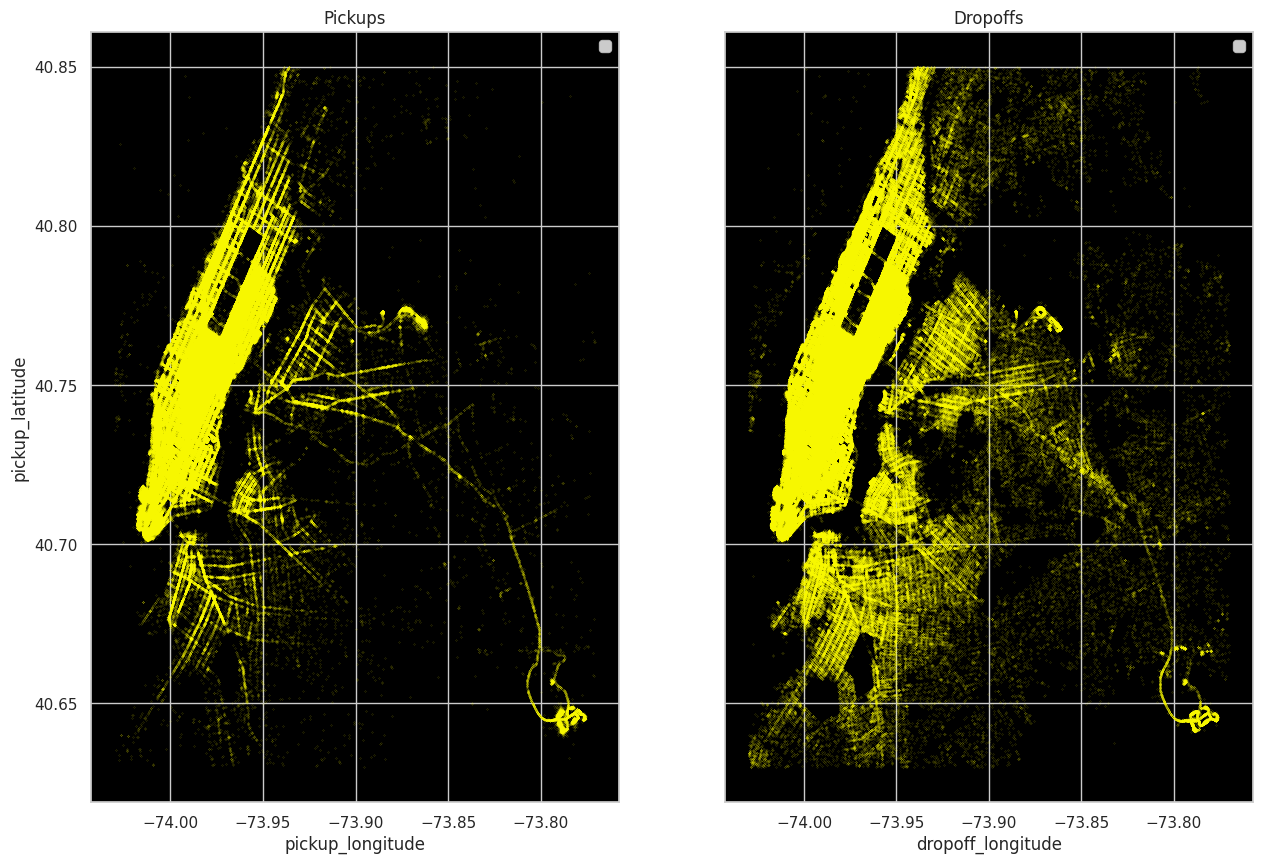

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow',
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow',
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black')

In [15]:
LaGuardia = {
    "minLat": 40.76,
    "maxLat": 40.78,
    "minLong": -73.895,
    "maxLong": -73.855
}
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

LaGuardiaData = train[(train['pickup_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train[(train['pickup_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]
LaGuardiaData = train[(train['dropoff_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train[(train['dropoff_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]

m = folium.Map(
    location=[40.7769, -73.8740],
    zoom_start=12
)
folium.Marker(location=[40.7769, -73.8740],icon=folium.Icon(color='black') ,popup='LA Guardia International Airport').add_to(m)

shortTripsDF=LaGuardiaData[LaGuardiaData.trip_duration==900]

lines = [
    {
        'coordinates': [
            [shortTripsDF.pickup_longitude.iloc[index], shortTripsDF.pickup_latitude.iloc[index]],
            [shortTripsDF.dropoff_longitude.iloc[index], shortTripsDF.dropoff_latitude.iloc[index]],
        ],
        'dates': [
        str(shortTripsDF.pickup_datetime.iloc[index]),
        str(shortTripsDF.dropoff_datetime.iloc[index])
        ],
        'color': 'gold'
    }
    for index in range(100)
]
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': line['weight'] if 'weight' in line else 10
            }
        }
    }
    for line in lines
]

plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT24H', add_last_point=True).add_to(m)
m


# Explore Data

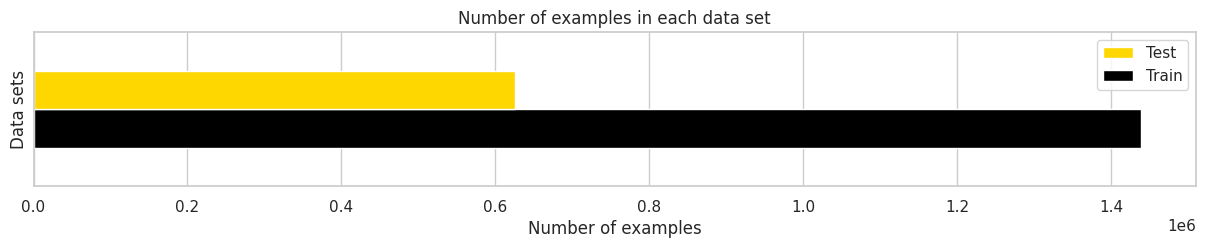

In [16]:
pd.DataFrame({'Train': [train.shape[0]], 'Test': [test.shape[0]]}).plot.barh(
    figsize=(15, 2), legend='reverse',  color=["black","gold"])
plt.title("Number of examples in each data set")
plt.ylabel("Data sets")
plt.yticks([])
plt.xlabel("Number of examples");

In [17]:
print("Training headcount is %i." % train.shape[0])
print("Testing headcount is %i." % test.shape[0])

Training headcount is 1438626.
Testing headcount is 625134.


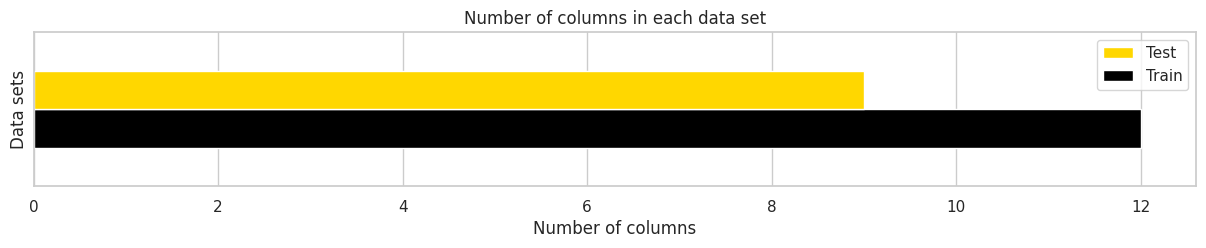

In [18]:
pd.DataFrame({'Train': [train.shape[1]], 'Test': [test.shape[1]]}).plot.barh(
    figsize=(15, 2), legend='reverse',  color=["black","gold"])
plt.title("Number of columns in each data set")
plt.ylabel("Data sets")
plt.yticks([])
plt.xlabel("Number of columns");

## Describing the data

In [19]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dropoff_month
count,1438626.00,1438626,1438626,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00
mean,1.53,2016-04-01 09:28:44.031634432,2016-04-01 09:44:30.023936,1.66,-73.97,40.75,-73.97,40.75,945.99,3.52
min,1.00,2016-01-01 00:00:17,2016-01-01 00:03:31,0.00,-74.03,40.63,-74.03,40.63,1.00,1.00
25%,1.00,2016-02-17 15:50:16.750000128,2016-02-17 16:06:05,1.00,-73.99,40.74,-73.99,40.74,394.00,2.00
50%,2.00,2016-04-01 16:03:35.500000,2016-04-01 16:22:34,1.00,-73.98,40.75,-73.98,40.75,656.00,4.00
75%,2.00,2016-05-15 03:04:43.500000,2016-05-15 03:17:08,2.00,-73.97,40.77,-73.96,40.77,1059.00,5.00
max,2.00,2016-06-30 23:59:39,2016-07-01 23:02:03,6.00,-73.77,40.85,-73.77,40.85,3526282.00,7.00
std,0.50,NaN,NaN,1.31,0.04,0.03,0.03,0.03,5252.16,1.68


In [20]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.00,625134.00,625134.00,625134.00,625134.00,625134.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75
std,0.50,1.31,0.07,0.03,0.07,0.04
min,1.00,0.00,-121.93,37.39,-121.93,36.60
25%,1.00,1.00,-73.99,40.74,-73.99,40.74
50%,2.00,1.00,-73.98,40.75,-73.98,40.75
75%,2.00,2.00,-73.97,40.77,-73.96,40.77
max,2.00,9.00,-69.25,42.81,-67.50,48.86


Looking at count of all columns, we can conclude that we have no missing values. Thats cool! party is gonna be bang on!

### Analyze variables
We will analyze individual features and their relations with target variable to find out how individual feature co relates with target variable. Also we will find out how important is single feature or it's transformation to predict target variable.

#### Univariate Analysis
Analyzing single feature at a time is called as univariate analysis.


####What is the Trip duration?
Trip Duration is the best friend of ours who's throwing party. Trip Duration is the reason for our pursuit (of happiness).

Trip duration: "Come, Poonam, we must prepare for tonight."

Poonam: "Why? What are we going to do tonight."

Trip duration: "Same thing we do every night, Poonam. Try to take over the world!"

Let's catch the last cab to New York!

We will plot trip duration of each taxi ride, target variable also called as dependent variable.

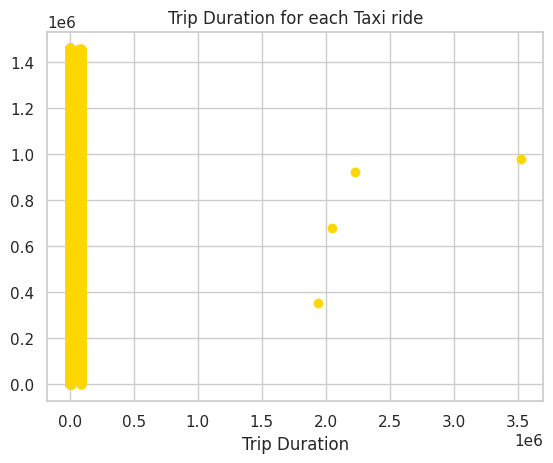

In [21]:
plt.scatter(train.trip_duration,train.index,color="gold")
plt.xlabel("Trip Duration")
plt.title("Trip Duration for each Taxi ride");

Looks like some trips are going too far away from New York city(Long rides who knows). These are outliers. Since the evaluation metrics is RMSLE(Root Mean Squared Logarithmic Error), we can log transform trip duration and use RMSE(Root Mean Squared Error) for training. So that outliers won't affect model performance much. Don't forget to take exponential of it while submitting submission file.

In [22]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

<ipython-input-23-58edb61be27b>:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc=0)
<ipython-input-23-58edb61be27b>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc=0)


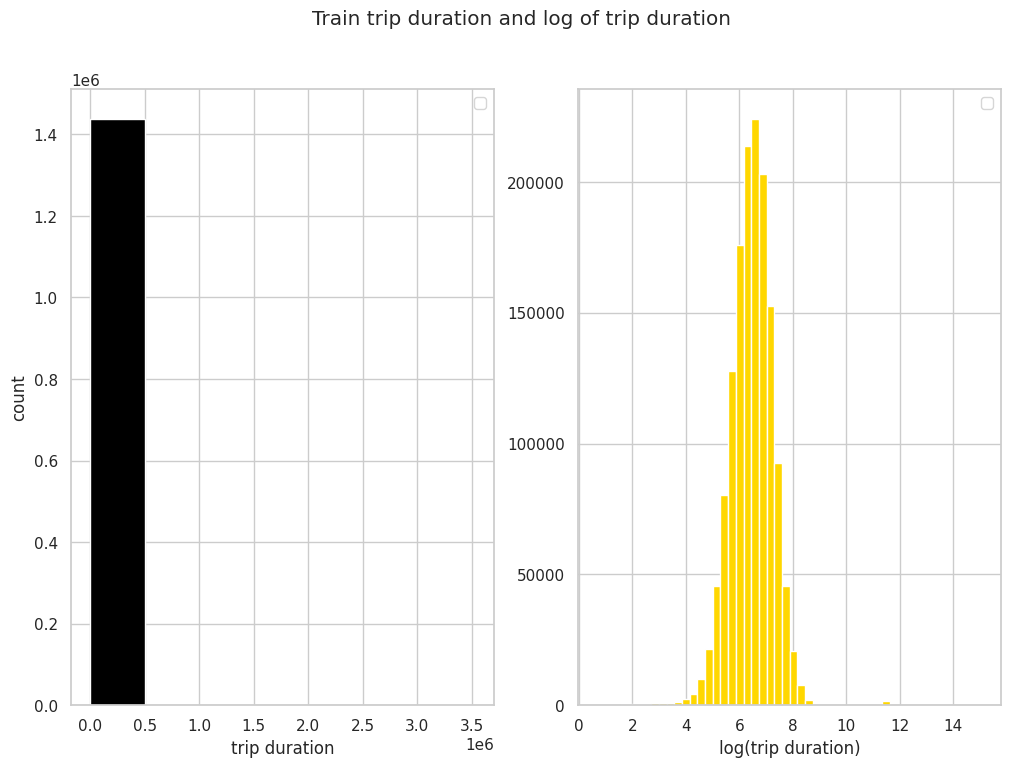

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Train trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(train.trip_duration,color='black',bins=7)
ax2.hist(train.log_trip_duration,bins=50,color='gold');

In [24]:
print("Skewness: %f" % train['log_trip_duration'].skew())
print("Kurtosis: %f" % train['log_trip_duration'].kurt())

Skewness: -0.265401
Kurtosis: 3.881358


# Categorical Features
Let's pick up some more friends of Trip Duration.

###Who is famous Vendor?
Ok, who is better at night driving, anyone?

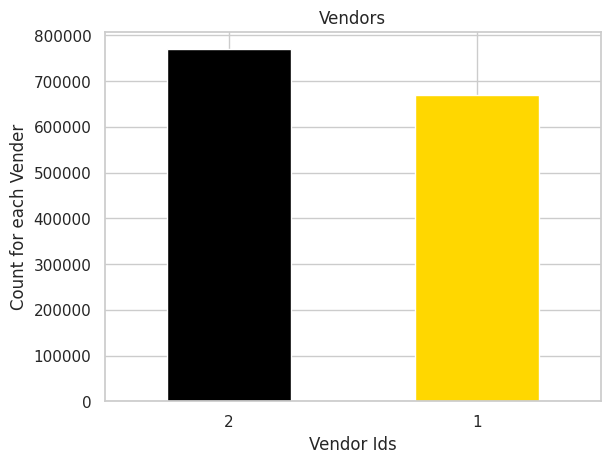

In [25]:
train["vendor_id"].value_counts().plot(kind='bar',color=["black","gold"])
plt.xticks(rotation='horizontal')
plt.title("Vendors")
plt.ylabel("Count for each Vender")
plt.xlabel("Vendor Ids");

Only 2 Vendors are there, they can be representing 2 taxi companies. Vendor 2 has more share in taxi rides in New York city.(Better drivers ;))

####How many passengers are traveling together?
Wht's your buddy group size??

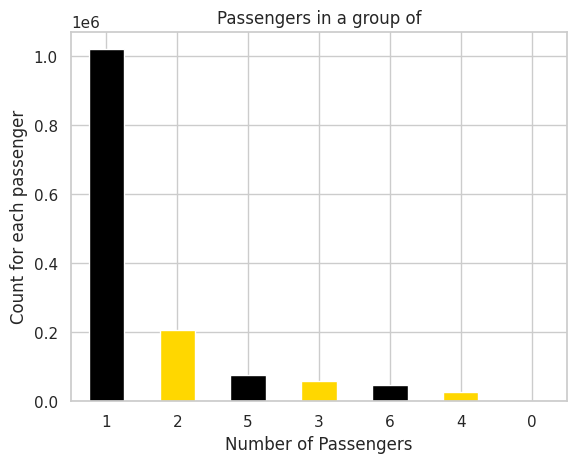

In [26]:
train["passenger_count"].value_counts().plot(kind='bar',color=["black","gold"])
plt.title("Passengers in a group of")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for each passenger")
plt.xlabel("Number of Passengers");

1. Most popular choice of travel is single.
2. 2nd popular way of ride is with a single friend.
3. May be for long cars popular choice of travel is in group of 5 and then in group of 6 people.
4. There are only 3 trips in group of 7 and single trip in group of 8 and 9 each.
5. There are 60 trips with zero passengers. Those must be outliers and have to be removed. Because no taxi ride can happen without passenger, at least paid one.

####Whether the Trip Details are Stored Or Forwarded?
Time for poses and flashes, let's have selfies for facebook and whatsapp DPs.

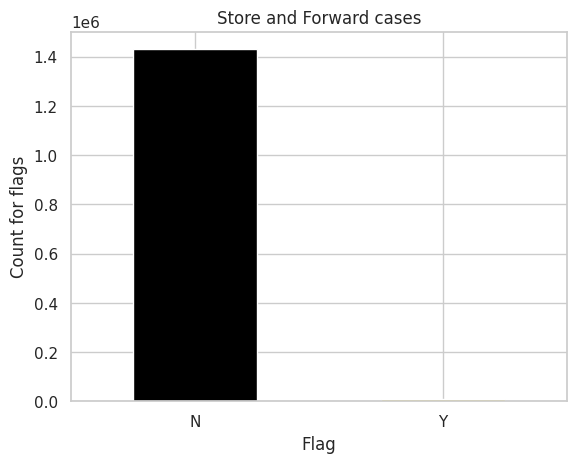

In [27]:
train["store_and_fwd_flag"].value_counts().plot(kind='bar',color=["black","gold"])
plt.title("Store and Forward cases")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for flags")
plt.xlabel("Flag");

Almost all the journey details were immediately sent to vendors. Very few stored in device memory may be due to bad signal or bad weather.

# Feature Engineering
####How about Dates and timings of the trips? - our temporal friends
We can extract lot of insights from dates and time data we have.

1. Pickup hour rushes can define start of office timings and drop offs in evening can tell till what time New Yorkers work.
2. Weekdays and weekends can show another angle of city life. Weekends people will be getting up late and starting day late compared to weekdays. Also parties can go beyond midnight hours on weekends.
3. We can also look out for some kind of seasonality. For example, during winter seasons traffic will be going slow due to snowfalls or wetness on Roads. So, trip Duration will be longer in winters than other seasons.

In [29]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

for df in (train,test):
    # Dates
    df['pickup_date'] = df['pickup_datetime'].dt.date

    # day of month 1 to 30/31
    df['pickup_day'] = df['pickup_datetime'].dt.day

    #month of year 1 to 12
    df['pickup_month'] = df['pickup_datetime'].dt.month

    #weekday 0 to 6
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday

    #week of year
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.isocalendar().week # Use isocalendar().week instead of weekofyear

    #hour of day 0 to 23
    df['pickup_hour'] = df['pickup_datetime'].dt.hour

    #minute of hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute

    # day of year
    df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear

train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test['pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

##Seasonality
"To everything there is a season, a time for every purpose under the sun.”

A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period. Hence, seasonal time series are sometimes called periodic time series.

Let's find out seasonal patterns in our data.

##Taxi trips By Months
Lets plot trip durations for each month. Which one is favourite party month for you guyz? Mine is May ;)

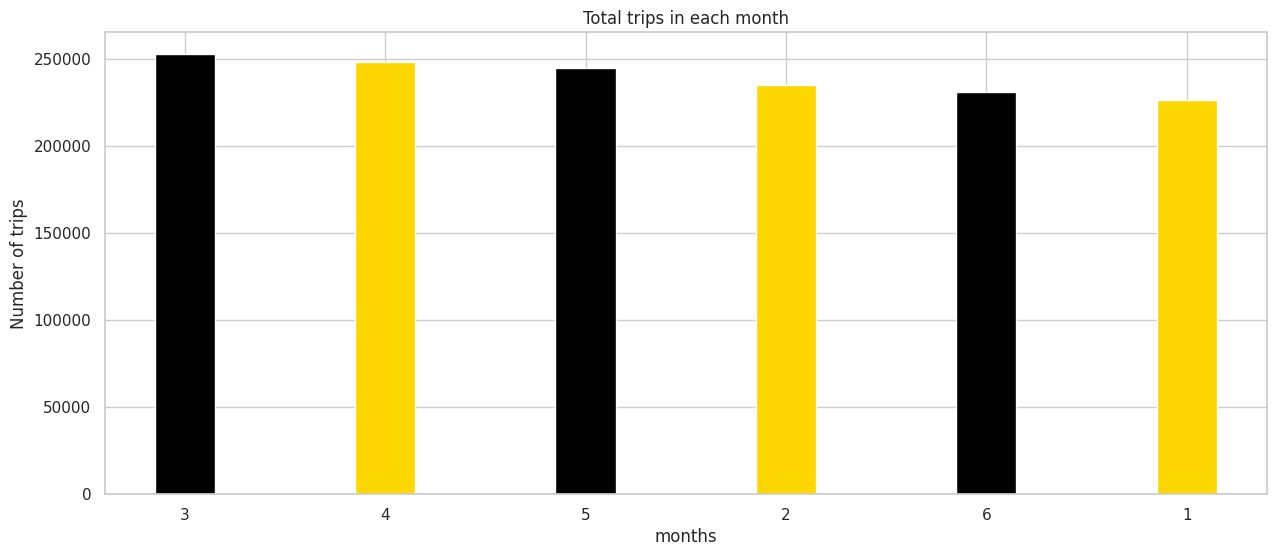

In [30]:
plt.figure(figsize=(15, 6))
train.pickup_month.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");

We have data from January to June of 2016. Highest number of trips happened in March and lowest in January.

#### Month and Trip Durations Together with Vendor Contribution
Since we have kernel memory limit , I have taken subset of data

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 30.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 33.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 30.1% of the points cannot be plac

<Axes: xlabel='pickup_month', ylabel='log_trip_duration'>

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 32.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 36.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 33.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 37.6% of the points cannot be plac

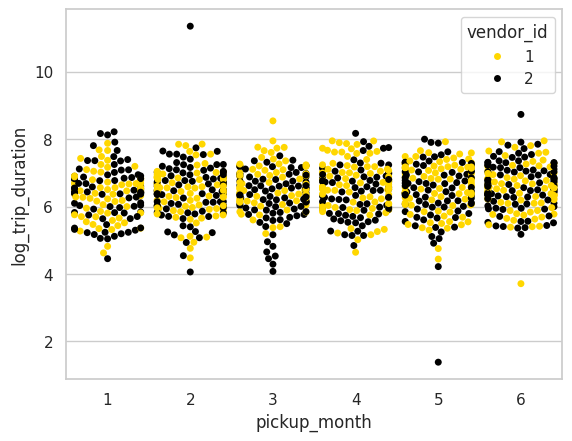

In [32]:
sns.swarmplot(x='pickup_month', y='log_trip_duration', hue='vendor_id', data=train[:1000], palette={1: 'gold', 2: 'black'})

####Taxi Trips by Pickup Dates

In [41]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.io import output_file

# 그래프를 HTML로 저장
output_file("taxi_trips_by_date.html")  # 이 파일을 열면 브라우저에서 그래프가 보입니다

# 날짜별 택시 이용 횟수
tripsByDate = train['pickup_date'].value_counts().sort_index()

# x, y 값 준비
x, y = tripsByDate.index, tripsByDate.values

# Bokeh figure 설정
plot = figure(
    x_axis_type="datetime",
    tools="",
    toolbar_location=None,
    x_axis_label='Dates',
    y_axis_label='Taxi trip counts',
    title='Hover over points to see taxi trips'
)

# 선 그래프 추가
plot.line(x, y, line_dash="4 4", line_width=1, color='gold')

# 점 그래프 추가 (Bokeh 3.4+ 호환)
cr = plot.scatter(
    x, y,
    size=20,
    marker="circle",
    fill_color="gold", hover_fill_color="black",
    fill_alpha=0.05, hover_alpha=0.5,
    line_color=None, hover_line_color="black"
)

# y축 과학적 표기 비활성화
plot.left[0].formatter.use_scientific = False

# 호버 툴 추가
plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

In [42]:
from bokeh.plotting import figure, output_file, save
from IPython.display import IFrame

# HTML로 저장
output_file("taxi_trips_by_date.html")

# Bokeh 시각화 객체 생성
plot = figure(title="Taxi Trips by Date", x_axis_type="datetime")
plot.line(x, y, line_dash="4 4", line_width=1, color='gold')
plot.scatter(x, y, size=20, marker="circle", fill_color="gold", fill_alpha=0.1)

# HTML 파일 저장만! show() X
save(plot)

# Colab 셀 안에 삽입
IFrame("taxi_trips_by_date.html", width=900, height=500)

If you hover on the lines of above plot you can see all taxi rides that took place in those particular dates. Lowest spike is around end of January. Yes you guessed it right. Its due to heavy snowfall happened in New York on 23rd and 24th January. April and March were busy months recorded with highest number of pickups.

In [44]:
print("Highest number of pickups  i.e", tripsByDate[0] , "happened on", str(tripsByDate.index[0]))
print("And lowest number of pickups  i.e", tripsByDate[tripsByDate.size-1] , "happened on",
      str(tripsByDate.index[tripsByDate.size-1]), "due to heavy snowfall in New York.")

Highest number of pickups  i.e 7011 happened on 2016-01-01
And lowest number of pickups  i.e 7493 happened on 2016-06-30 due to heavy snowfall in New York.


<ipython-input-44-2bb31a467fc0>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Highest number of pickups  i.e", tripsByDate[0] , "happened on", str(tripsByDate.index[0]))
<ipython-input-44-2bb31a467fc0>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("And lowest number of pickups  i.e", tripsByDate[tripsByDate.size-1] , "happened on",


### Dashing through the snow

In [45]:
snowFallDF=train[(train['pickup_dayofyear'] == 24) |  (train['pickup_dayofyear'].any() == 23)]
snowFallDF.shape

(3337, 23)

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:896: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:896: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


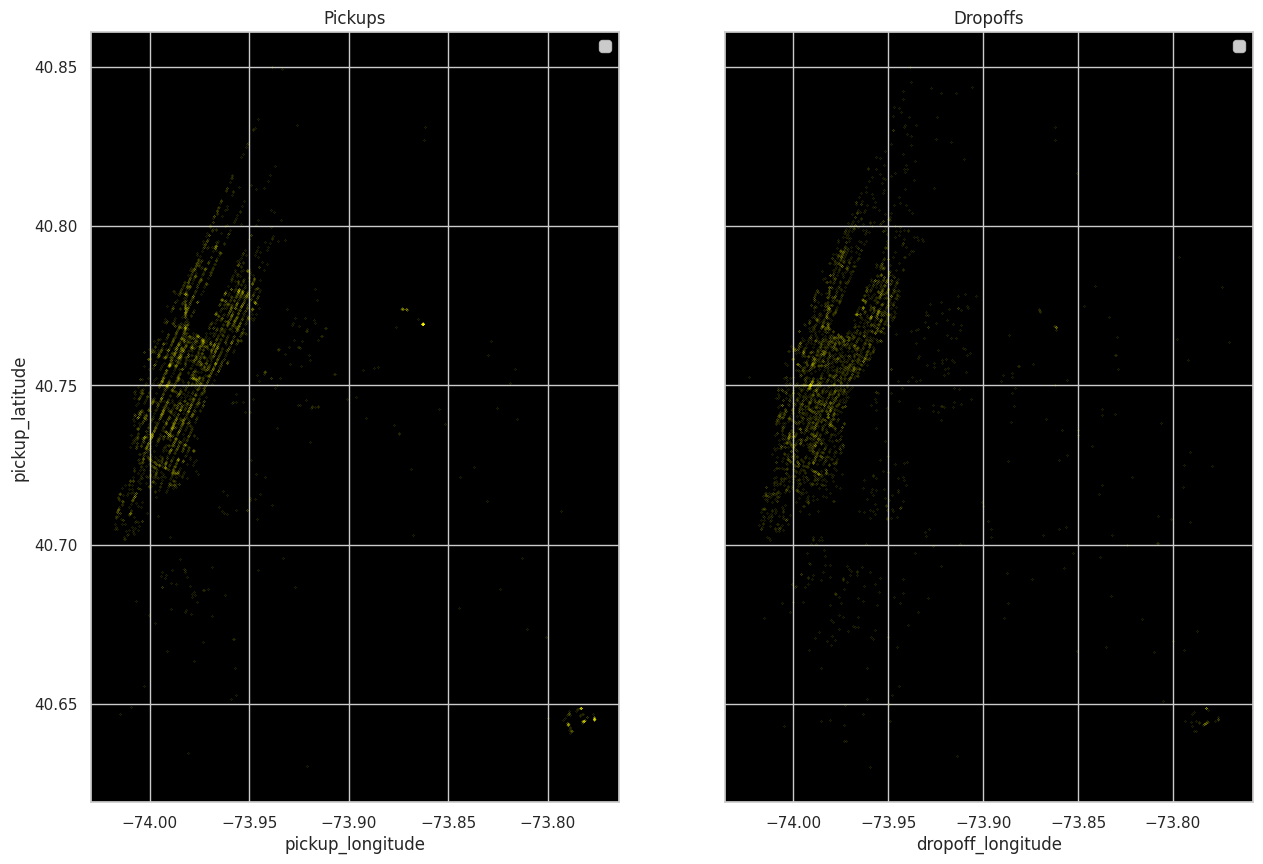

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

snowFallDF.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow',
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

snowFallDF.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow',
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black')

Looks like very less trips have happened due to heavy snowfall. Hope travellers were safe! While doing feature engineering we will get help of external weather dataset,which has snowfall information in New York.

### Taxi Trips by Dropoff Date

In [48]:
train['dropoff_date'] = train['dropoff_datetime'].dt.date
tripsByDropoffDate=train['dropoff_date'].value_counts()

# Basic plot setup
plot = figure( x_axis_type="datetime", tools="",
              toolbar_location=None, x_axis_label='Dates',
            y_axis_label='Taxi trip counts', title='Hover over points to see taxi trips')

x,y= tripsByDropoffDate.index, tripsByDropoffDate.values
plot.line(x,y, line_dash="4 4", line_width=1, color='gold')

cr = plot.scatter(x, y, size=20,
                fill_color="gold", hover_fill_color="black",
                fill_alpha=0.05, hover_alpha=0.5,
                line_color=None, hover_line_color="black")
plot.left[0].formatter.use_scientific = False

plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

show(plot)
train.drop('dropoff_date',axis=1,inplace=True)

If you hover on the lines of above plot you can see all taxi rides that happened in those particular dates. Lowest spike is around end of June i.e 1st of July. We have 1 extra day dropoff data in training dataset and March were busy months recorded with highest number of pickups.

In [49]:
print("Highest number of dropoffs  i.e", tripsByDropoffDate[0] , "happened on", str(tripsByDropoffDate.index[1]))
print("And lowest number of dropoffs  i.e", tripsByDropoffDate[tripsByDropoffDate.size-1] , "happened on",
      str(tripsByDropoffDate.index[tripsByDropoffDate.size-1]))

Highest number of dropoffs  i.e 9681 happened on 2016-03-05
And lowest number of dropoffs  i.e 123 happened on 2016-07-01


<ipython-input-49-0a2384cc4839>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Highest number of dropoffs  i.e", tripsByDropoffDate[0] , "happened on", str(tripsByDropoffDate.index[1]))
<ipython-input-49-0a2384cc4839>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("And lowest number of dropoffs  i.e", tripsByDropoffDate[tripsByDropoffDate.size-1] , "happened on",


#### Taxi Trips By Pickup Day of the Month

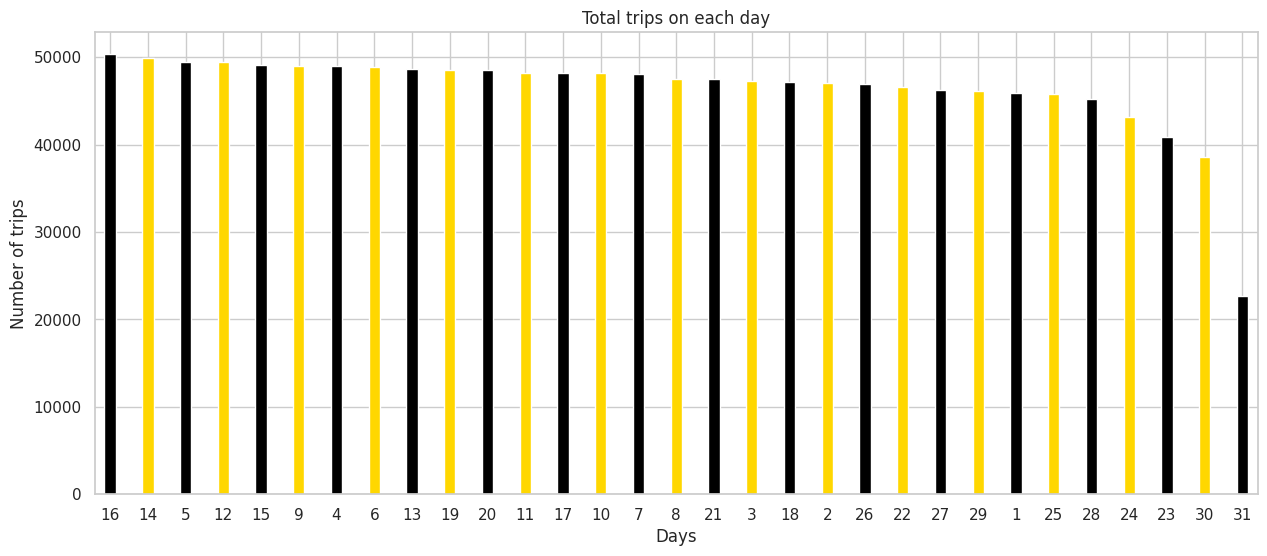

In [50]:
plt.figure(figsize=(15, 6))
train.pickup_day.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("Days")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each day");

1. Highest number of trips happened on 16th of the month while lowest on 31st.
2. 30th and 31st have less trips because we have 6 months data and 30th and 31st came only 3 times each.

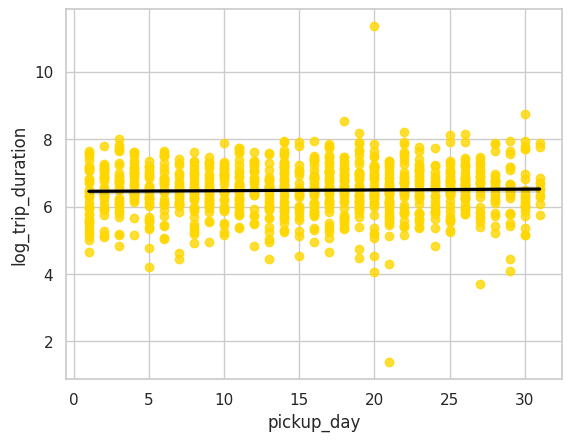

In [53]:
sns.regplot(x=train.pickup_day[:1000], y=train.log_trip_duration[:1000], color='gold', line_kws={'color':'black'});

The median of trip duration is approximately 6.48. There is clearly linear relationship between these two. Hmm!! The solid black line depicts linear regression model fit.

####Taxi Trips By Pickup WeekDays

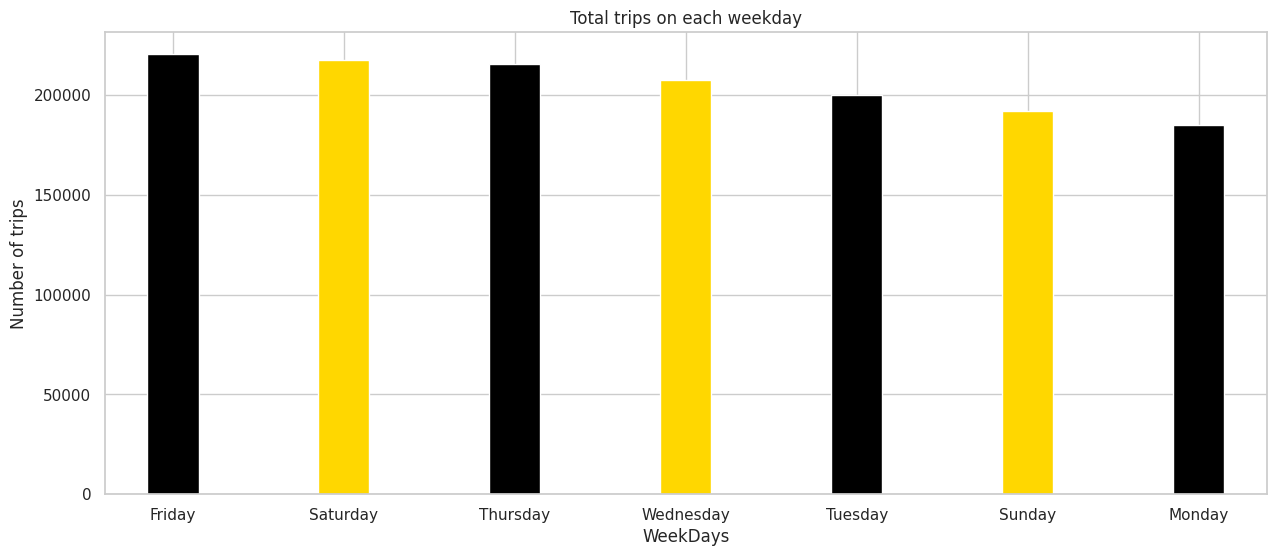

In [56]:
train['pickup_weekday_name'] = train['pickup_datetime'].dt.day_name() # Use day_name() instead of weekday_name
plt.figure(figsize=(15, 6))
train.pickup_weekday_name.value_counts().plot(kind='bar', color=["black", "gold"], align='center', width=0.3)
plt.xlabel("WeekDays")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each weekday");
train.drop('pickup_weekday_name', axis=1, inplace=True)

Highest number of trips took place on every Friday of the week while lowest on Mondays. (Monday blues :() Thursday and Saturday were also busy days.

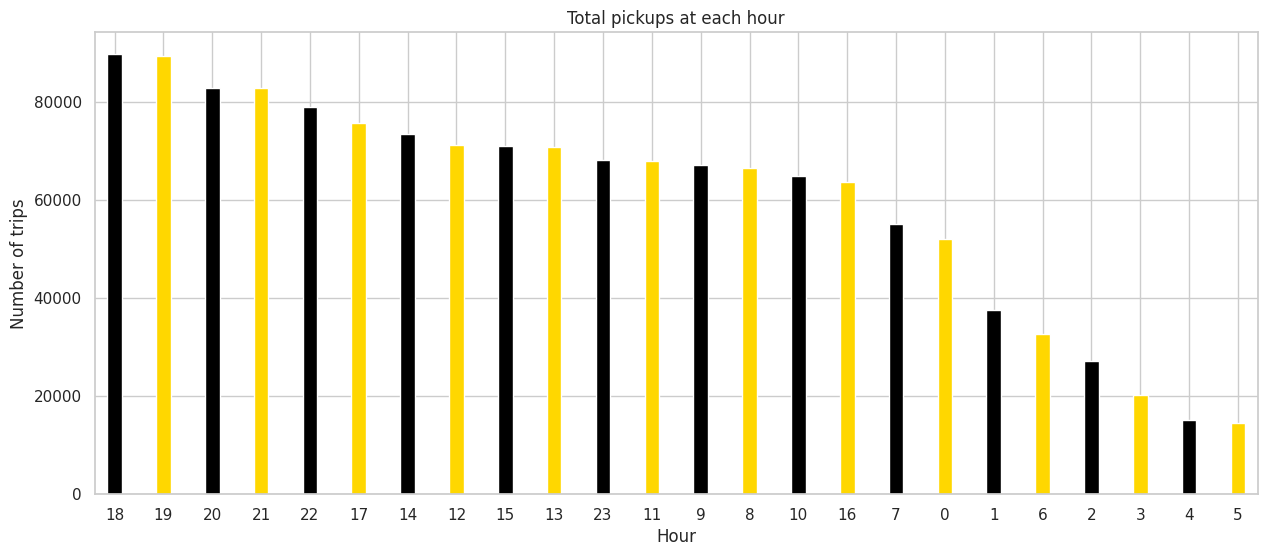

In [57]:
plt.figure(figsize=(15, 6))
train.pickup_hour.value_counts().plot(kind='bar',color=["black","gold"],align='center',width=0.3)
plt.xlabel("Hour")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total pickups at each hour");

Most pickups were at 6 O'Clock in the evening may be due to people are leaving from work and least at 5 O'Clock early morning. Demand for pick ups starts from 6 in the early morning and it keeps growing as day passes.